# **Analisis de sentimientos en reviews de peliculas**

En este notebook se realiza un pipeline que recibe un archivo de audio (acepta multiples formatos), que contendra la opinion del usuario sobre determinada pelicula e identificara si la opinion pertenece a una de las siguientes  5 clases

1. Negativa
2. Algo negativa
3. Neutral
4. Algo positiva
5. Positiva

Los pasos que seguimos para realizar esta tarea fueron



*   Usar **whisper** para transcribir el archivo de audio

*   Traducir la transcripcion al ingles usando el modelo **MARIAMT**. Observamos que la traduccion realizado por whisper contenia muchos errores


*   Realizar fine-tuning al modelo **Roberta For SequenceClassification** usando el movie reviews dataset de kaggle disponible en : https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data

*   Evaluar y poner al prueba el funcionamiento del modelo


**Acerca del dataset**

«Hay una delgada línea entre lo simpáticamente anticuado y lo chapucero, y El conde de Montecristo... nunca se decanta del todo por ninguno de los dos lados».

El conjunto de datos de críticas de cine de Rotten Tomatoes es un corpus de críticas de cine utilizado para el análisis de sentimientos, recopilado originalmente por Pang y Lee en su trabajo sobre bancos de árboles de sentimientos (sentiment banktrees), Socher et al. utilizaron Amazon's Mechanical Turk para crear etiquetas detalladas para todas las frases analizadas del corpus. Obstáculos como la negación de la frase, el sarcasmo, la brevedad, la ambigüedad del lenguaje y muchos otros hacen que la tarea de analisis de sentimientos sea muy difícil.

Se usaron modelos preentrenados disponibles en hugging face haciendo uso de la libreria transformers

# Instalar dependencias

In [ ]:
# Paso 1: Instalar las Dependencias
!pip install openai-whisper
!pip install torch
!pip install transformers
!pip install --no-cache-dir transformers sentencepiece
!pip install pydub
!pip install sacremoses

from transformers import MarianMTModel, MarianTokenizer
from transformers import pipeline
from google.colab import files
import whisper

import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFAutoModel
import pathlib, os, json
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cac

In [ ]:
#Paso 2: Hacer fine-tuning con el dataset de reviews de peliculas

# ![Roberta.png](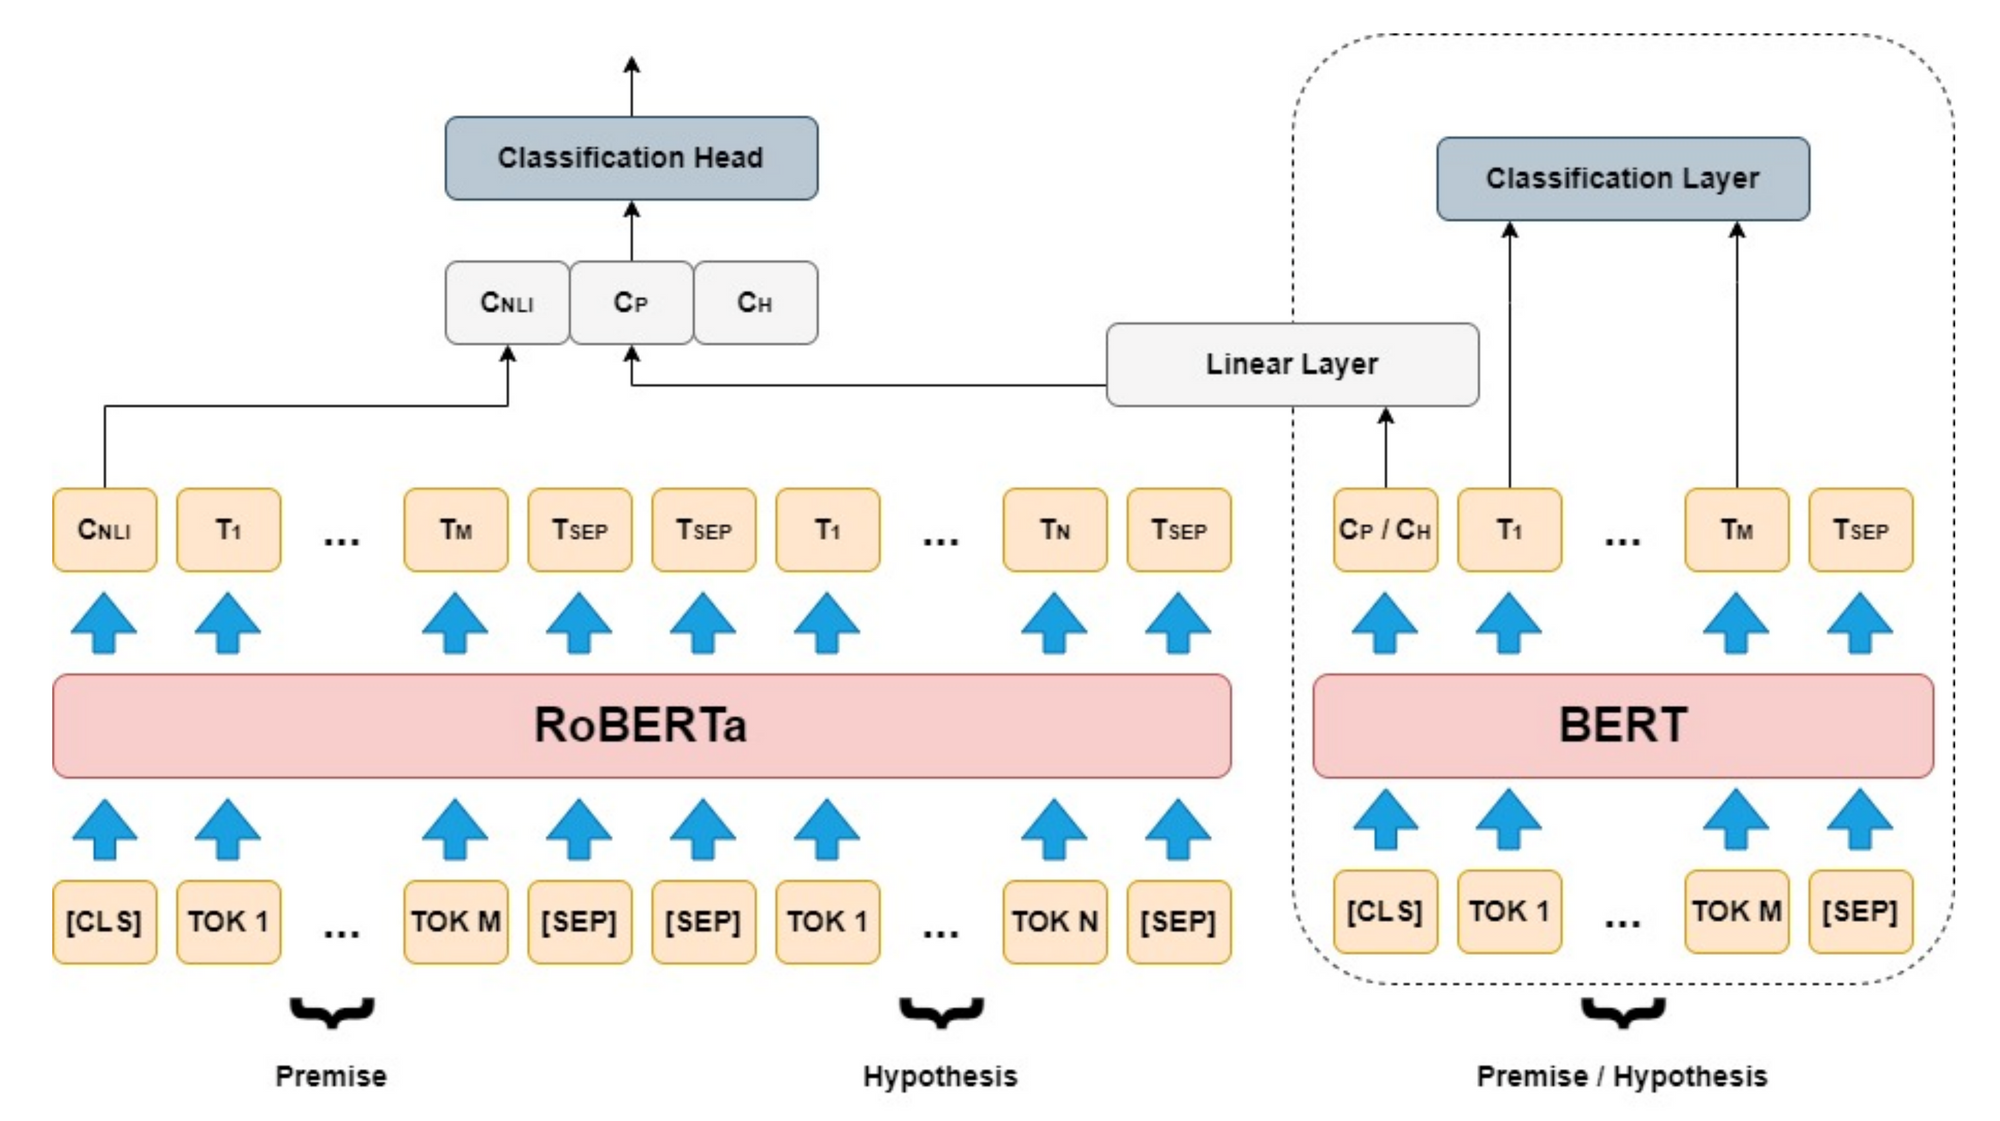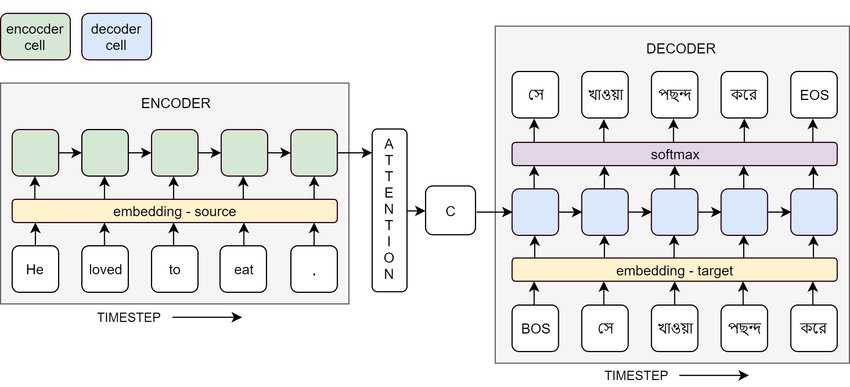)Roberta

# **RoBERTa: Robustly optimized BERT approach**

RoBERTa es una variante de BERT desarrollada por Facebook AI. Se basa en el mismo concepto de Transformer que BERT pero con algunas mejoras clave:



1.   Más datos y más tiempo de entrenamiento
2.   Eliminación del NSP (Next Sentence Prediction):
3.   Ajustes en la secuencia de entrada
4.   Enmascarado dinamico




#FINE TUNIG BERT WITH MOVIES REVIEWS DATASET V1

In [ ]:
# Descargamos el dataset desde kaggle
api_key = {"username":"miguelnngel","key":"563e2f4def420c520a1af7db8800ea37"}

kaggle_path = pathlib.Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)
with open(kaggle_path/'kaggle.json', 'w') as handle:
 json.dump(api_key, handle)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', './')

100%|██████████| 1.28M/1.28M [00:00<00:00, 7.24MB/s]

In [ ]:
from zipfile import ZipFile
with ZipFile('./train.tsv.zip', 'r') as file:
 file.extractall('./data')

In [ ]:
#Analisis exploratorio de datos

df = pd.read_csv('./data/train.tsv',sep='\t')
df.head(5)

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

<Axes: xlabel='Sentiment'>

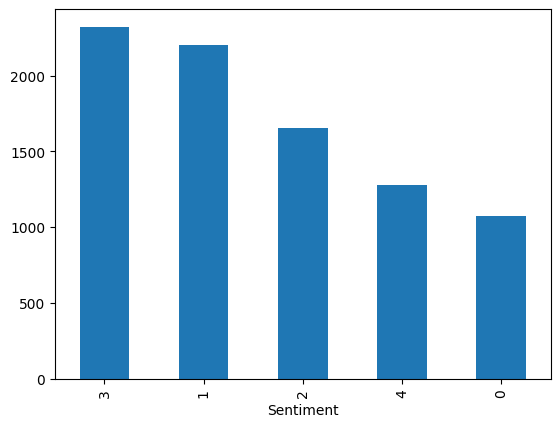

In [ ]:
df = df.drop_duplicates('SentenceId',keep='first')
df['Sentiment'].value_counts().plot(kind='bar')

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
epochs = 2
def plot_model(metric="loss", epochs=epochs):
  plt.plot(range(epochs), history.history[metric], c='blue', alpha=0.7, label=f"Training {metric}")
  plt.plot(range(epochs), history.history[f"val_{metric}"], c='red', alpha=0.7, label=f"Validation {metric}")
  plt.title(f"Training Vs Validation {metric}")
  plt.legend(loc="best")
  plt.show()

In [ ]:
# Inicializamos el tokenizador BERT con el modelo preentrenado 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Cargamos el conjunto de datos
df = pd.read_csv('./data/train.tsv', sep='\t')
df = df.drop_duplicates('SentenceId', keep='first')  # Eliminamos duplicados basados en 'SentenceId'

# Verificamos la distribución de clases en el conjunto de datos
print(df['Sentiment'].value_counts())

# Definimos la longitud máxima de las secuencias
max_len = 128

# Función para convertir texto a características adecuadas para el modelo
def to_feature(text, max_len=max_len, padding='max_length'):
    tokens = tokenizer(text.numpy().decode(), max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# Función para mapear texto y etiqueta a un formato adecuado para el modelo
def to_feature_map(text, label):
    input_ids, attention_mask = tf.py_function(to_feature, inp=[text], Tout=[tf.int32, tf.int32])
    input_ids, attention_mask = input_ids[0], attention_mask[0]
    input_ids.set_shape([max_len])
    attention_mask.set_shape([max_len])
    x = {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }
    return x, label

# Codificamos las etiquetas como one-hot vectors
labels = np.zeros((len(df), df['Sentiment'].max() + 1))
labels[np.arange(len(df)), df['Sentiment'].values] = 1

with tf.device('/cpu:0'):
    batch_size = 16
    text_data = df['Phrase'].values

    # Función para crear el conjunto de datos de entrenamiento
    def make_dataset(text_data=text_data, labels=labels):
        dataset = tf.data.Dataset.from_tensor_slices((text_data, labels))
        dataset = dataset.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
        dataset = dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(100000)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    # Creamos el dataset
    dataset = make_dataset()

# Dividimos el dataset en conjuntos de entrenamiento y validación
train_split = int(len(df) / batch_size * 0.835)
train_dataset = dataset.take(train_split)
valid_dataset = dataset.skip(train_split)

# Definimos una clase de modelo personalizado que utiliza BERT
class CustomBERTModel(tf.keras.Model):
    def __init__(self, model_name):
        super(CustomBERTModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name)  # Cargamos el modelo BERT preentrenado
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(5, activation='softmax')  # Salida con 5 clases

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        sequence_output = self.bert(input_ids, attention_mask=attention_mask)[1]  # Usamos la salida del pooler de BERT
        x = self.dropout(sequence_output, training=training)
        x = self.dense1(x)
        return self.dense2(x)

# Instanciamos y compilamos el modelo
model_name = 'bert-base-cased'
model = CustomBERTModel(model_name)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, weight_decay=0.05),
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")])

# Entrenamos el modelo
epochs = 8
history = model.fit(train_dataset, validation_data=valid_dataset, batch_size=batch_size, epochs=epochs)

# Guardamos los pesos del modelo
model_dir = './bert_finetuned_model2'
os.makedirs(model_dir, exist_ok=True)
model.save(model_dir, save_format='tf')
tokenizer.save_pretrained(model_dir)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Sentiment
3    2321
1    2200
2    1655
4    1281
0    1072
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
445/445 [==============================] - 334s 484ms/step - loss: 1.3610 - accuracy: 0.4066 - val_loss: 0.9925 - val_accuracy: 0.5852
Epoch 2/8
445/445 [==============================] - 218s 467ms/step - loss: 1.0631 - accuracy: 0.5344 - val_loss: 0.7795 - val_accuracy: 0.6882
Epoch 3/8
445/445 [==============================] - 218s 468ms/step - loss: 0.8557 - accuracy: 0.6324 - val_loss: 0.5761 - val_accuracy: 0.7898
Epoch 4/8
445/445 [==============================] - 217s 466ms/step - loss: 0.6735 - accuracy: 0.7302 - val_loss: 0.4987 - val_accuracy: 0.8246
Epoch 5/8
445/445 [==============================] - 219s 469ms/step - loss: 0.5161 - accuracy: 0.7947 - val_loss: 0.3577 - val_accuracy: 0.8643
Epoch 6/8
445/445 [==============================] - 237s 512ms/step - loss: 0.3910 - accuracy: 0.8597 - val_loss: 0.2041 - val_accuracy: 0.9368
Epoch 7/8
445/445 [==============================] - 217s 466ms/step - loss: 0.2730 - accuracy: 0.9041 - val_loss: 0.1763 - val_ac

('./bert_finetuned_model2/tokenizer_config.json',
 './bert_finetuned_model2/special_tokens_map.json',
 './bert_finetuned_model2/vocab.txt',
 './bert_finetuned_model2/added_tokens.json')

In [ ]:
import shutil

# Directorio donde se guardó el modelo
model_dir = './bert_finetuned_model'
# Nombre del archivo ZIP
zip_filename = 'bert_finetuned_model.zip'

# Comprimir el directorio del modelo en un archivo ZIP
shutil.make_archive('bert_finetuned_model', 'zip', model_dir)

# Descargar el archivo ZIP
from google.colab import files
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
drive_destination = '/content/drive/My Drive/bert_finetuned_model'

# Copiar el directorio del modelo a Google Drive
shutil.copytree(model_dir, drive_destination)

print(f'Model directory copied to {drive_destination}')

Model directory copied to /content/drive/My Drive/bert_finetuned_model


#FINE TUNIG BERT WITH MOVIES REVIEWS DATASET V2 PYTORCH

In [ ]:
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import os

In [ ]:
#Se le da permisos al archivo llave kaggle.json el cual permite acceder a los repositorios de kaggle.
!chmod 600 kaggle.json
#Se crea una carpeta solo para la llave a usar en kaggle.
!mkdir ~/.kaggle/
#Copia del archivo kaggle a la carpeta creada anteriormente
!cp kaggle.json ~/.kaggle/
!ls

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
 drive						 'WhatsApp Ptt 2024-06-01 at 4.16.39 PM.mp3'
 kaggle.json					 'WhatsApp Ptt 2024-06-01 at 4.18.08 PM (1).mp3'
 sample_data					 'WhatsApp Ptt 2024-06-01 at 4.18.08 PM.mp3'
'WhatsApp Ptt 2024-06-01 at 4.16.39 PM (1).mp3'  'WhatsApp Ptt 2024-06-01 at 5.13.52 PM (1).ogg'
'WhatsApp Ptt 2024-06-01 at 4.16.39 PM (2).mp3'  'WhatsApp Ptt 2024-06-01 at 5.13.52 PM.ogg'


In [ ]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 115MB/s]


In [ ]:
!unzip sentiment-analysis-on-movie-reviews.zip

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [ ]:
# Cargar los datos de entrenamiento y prueba desde archivos CSV comprimidos
train=pd.read_csv('/content/train.tsv.zip',sep='\t')
test=pd.read_csv('/content/test.tsv.zip',sep='\t')

In [ ]:
train.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

In [ ]:
test.head()

PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00


![image.png](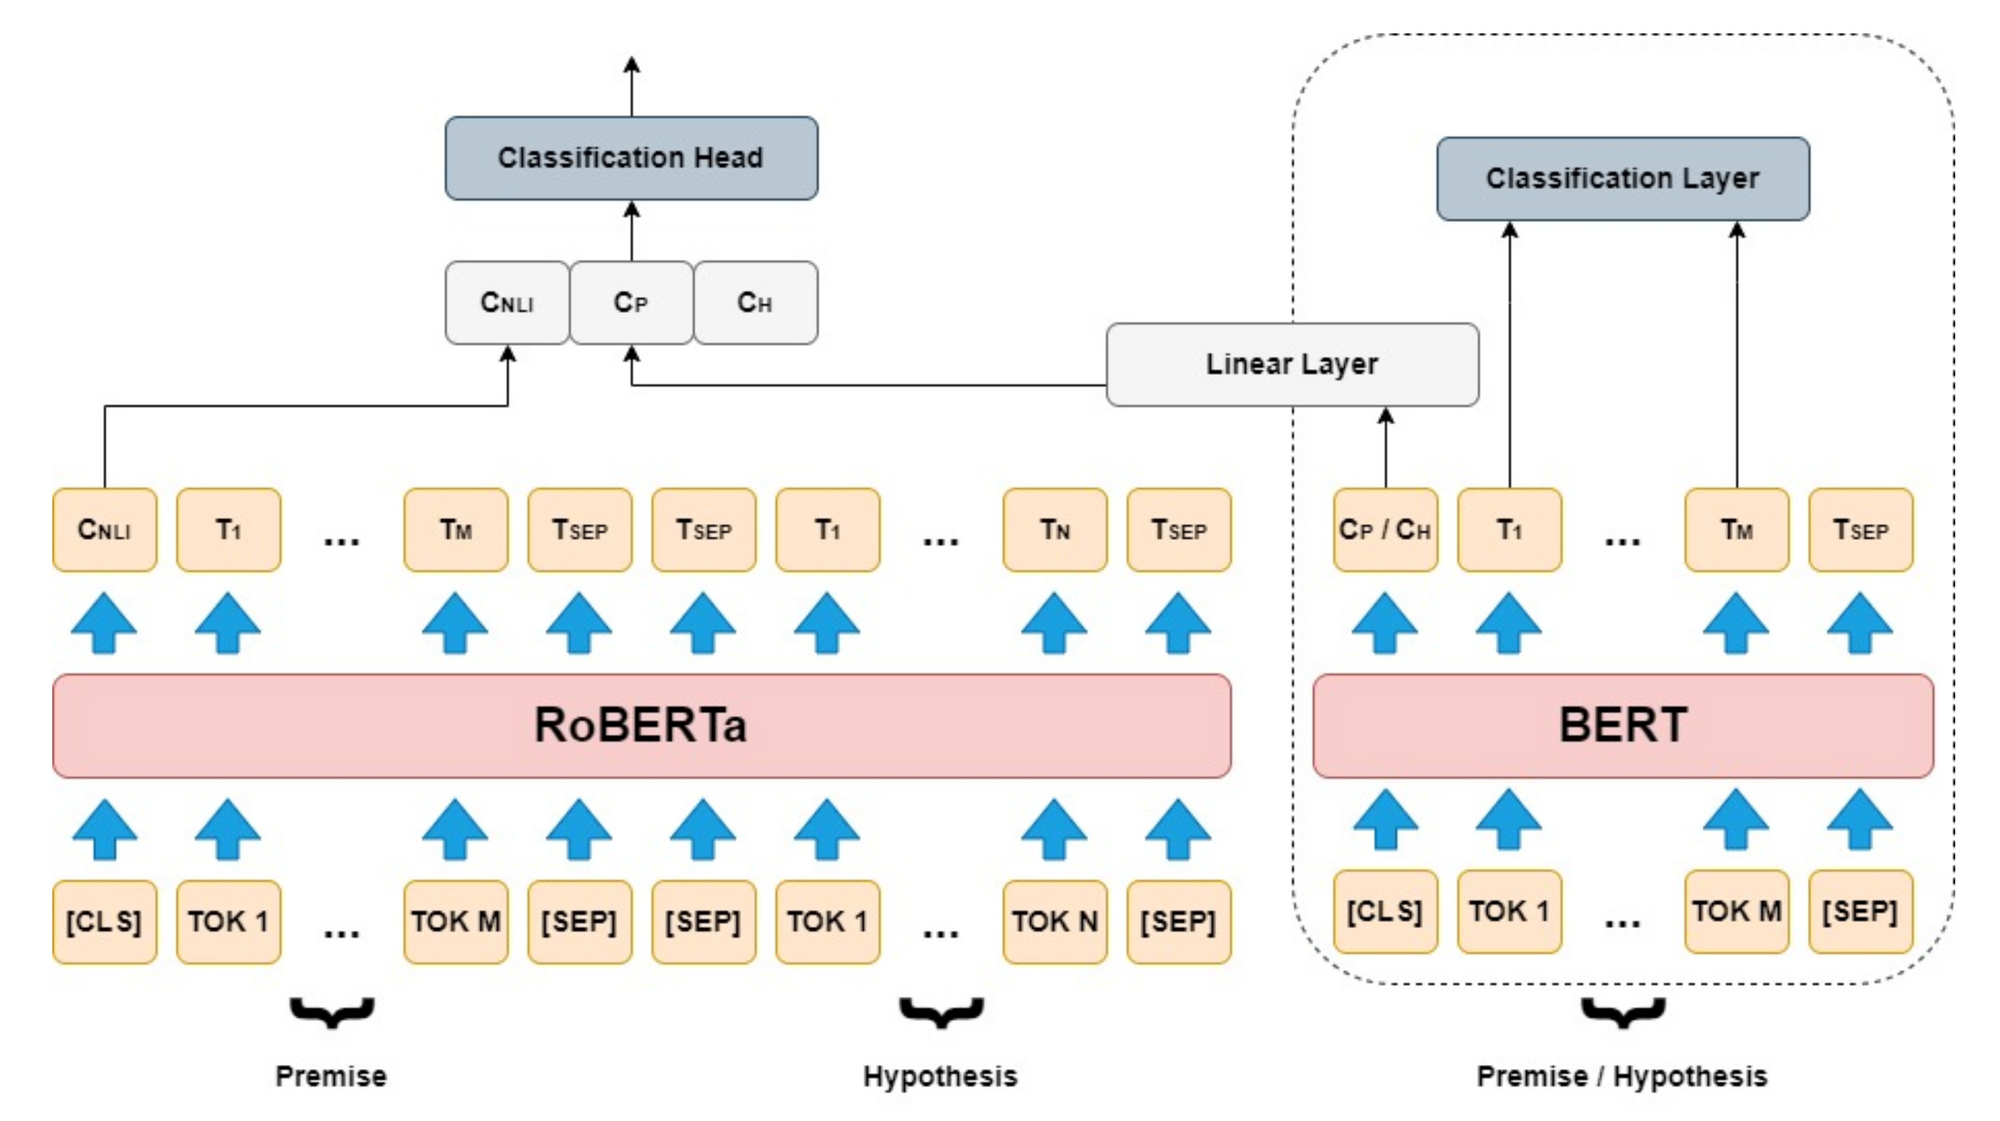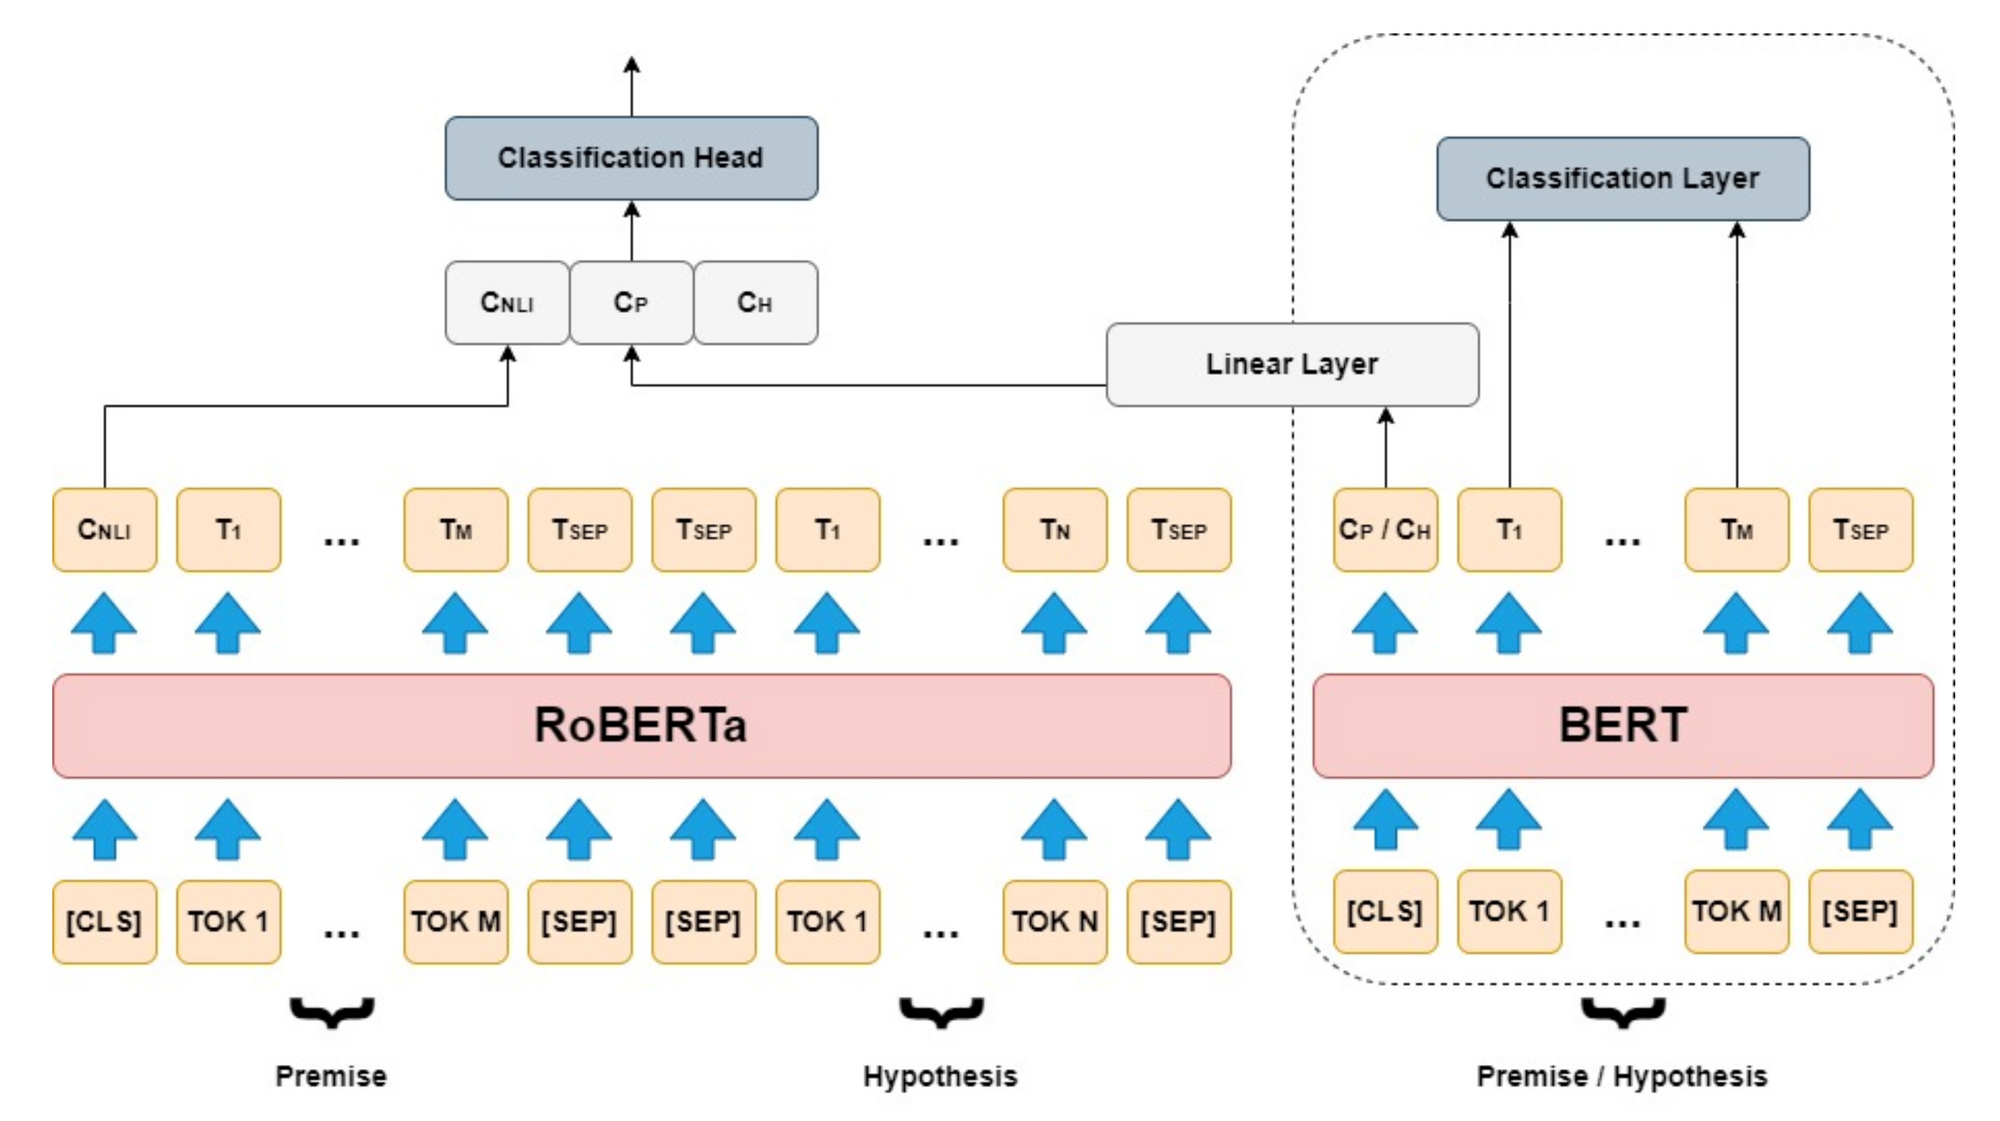)

In [ ]:
# Especificar el checkpoint del modelo preentrenado
checkpoint = "siebert/sentiment-roberta-large-english"

In [ ]:
# Importar las funciones y clases necesarias de transformers y otros módulos
from datasets import load_dataset
from datasets import load_metric

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler

import torch
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

In [ ]:
# Cargar el tokenizador y el modelo preentrenado desde el checkpoint especificado
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5, ignore_mismatched_sizes=True)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Definir la función de tokenización
def tokenize_function(example):
    return tokenizer(example, truncation=True)

# Aplicar la función de tokenización al conjunto de datos de entrenamiento
tokenized_datasets = train["Phrase"].map(tokenize_function)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
sent_list = train["Sentiment"].to_list()

# Añadir las etiquetas tokenizadas a los datos

for i in range(len(tokenized_datasets)):
    tokenized_datasets[i]['label'] = sent_list[i]
print(tokenized_datasets[1])
print(tokenized_datasets[:2])

{'input_ids': [0, 250, 651, 9, 11363, 1115, 4216, 16987, 5, 2329, 1580, 14, 99, 16, 205, 13, 5, 29910, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': 2}
0    [input_ids, attention_mask, label]
1    [input_ids, attention_mask, label]
Name: Phrase, dtype: object


In [ ]:
#DataLoader para el conjunto de datos de entrenamiento

train_dataloader = DataLoader(
    tokenized_datasets, shuffle=True, batch_size=64, collate_fn=data_collator
)

In [ ]:
# Configurar el optimizador y el scheduler de la tasa de aprendizaje
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}     # Mover el batch al dispositivo (GPU o CPU)
        outputs = model(**batch)                                # Pasar el batch por el modelo
        loss = outputs.loss
        loss.backward()                                         # Retropropagación del error

        optimizer.step()                                        # Actualizar los parámetros del modelo
        lr_scheduler.step()                                     # Actualizar el scheduler de la tasa de aprendizaje
        optimizer.zero_grad()                                   # Reiniciar los gradientes del optimizador
        progress_bar.update(1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7317 [00:00<?, ?it/s]

In [ ]:
# Guardar el modelo, el tokenizador y la configuración
output_dir = "./model_save/"
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")


# PIPELINE LENGUAJE

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Whisper


Whisper es un modelo de inteligencia artificial desarrollado por OpenAI para la transcripción automática de audio a texto con alta precisión. Utiliza técnicas avanzadas de aprendizaje profundo para manejar diversos tipos de audio y soporta múltiples idiomas y acentos. Entrenado en un extenso corpus de datos de audio, Whisper es robusto y preciso, incluso en condiciones acústicas desafiantes. Es útil en aplicaciones como la generación de subtítulos, transcripción de entrevistas y análisis de contenido hablado, y está disponible a través de API y bibliotecas de desarrollo para fácil integración y personalización.

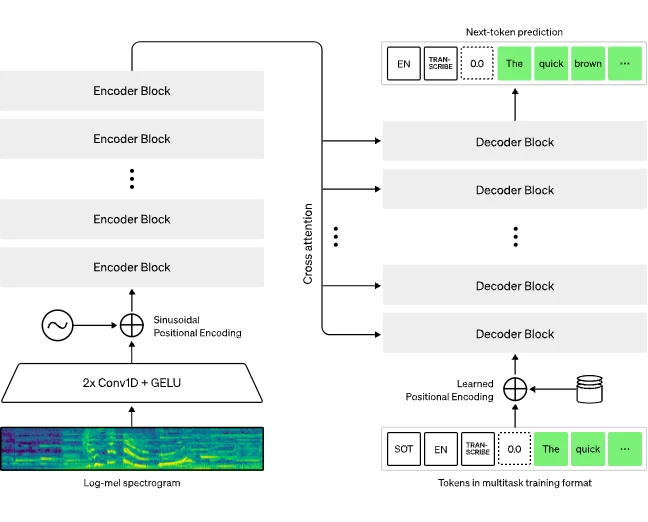

La arquitectura Whisper es un sencillo enfoque de extremo a extremo, implementado como un transformador codificador-decodificador.

El audio de entrada se divide en trozos de 30 segundos, se convierte en un espectrograma log-Mel y, a continuación, se pasa a un codificador.

 A continuación, se entrena un descodificador para que prediga la correspondiente leyenda de texto, entremezclada con tokens especiales que dirigen el modelo único para realizar tareas como la identificación del idioma, las marcas de tiempo a nivel de frase, la transcripción multilingüe del habla y la traducción del habla al inglés.




In [ ]:
# Paso 3: Subir el Archivo de Audio

model = whisper.load_model("small")

uploaded = files.upload()

# Asume que solo sube un archivo
audio_file_path = next(iter(uploaded))


# Paso 4: Transcribir el Audio en Español
result_es = model.transcribe(audio_file_path, language='es')
transcription_es = result_es['text']
print("Transcripción en Español:", transcription_es)

# Paso 5: Traducir el Audio Directamente al Inglés
result_en = model.transcribe(audio_file_path, task="translate")
transcription_translation_en = result_en['text']
print("Traducción al Inglés:", transcription_translation_en)

Saving WhatsApp Ptt 2024-06-01 at 4.16.39 PM.mp3 to WhatsApp Ptt 2024-06-01 at 4.16.39 PM (2).mp3


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcripción en Español:  Acción rápida y trepidante como pocas veces se ha visto, muy probablemente es de la última obra de George Miller. Chris Hemsworth ofrece una actuación increíblemente divertida y desquiciada, una de las mejores en 10 años. Añas de unas miradas feroces como el personaje del título y el elenco de apoyo se mantienen el mismo nivel.


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Traducción al Inglés:  Quick and exciting action as few times have seen, probably from the last work by George Miller. Chris Hemsworth offers an incredibly fun and fun act, one of the best in 10 years. Ane of some ferocious looks like the character of the title and the support cast remains the same level.


# **MARIAN-NMT**

El modelo de traduccion utilizado hace parte del proyecto OPUS-MT desarrollado por el grupo de investigación de Procesamiento de Lenguaje Natural de la Universidad de Helsinki. Este modelo en particular, Helsinki-NLP/opus-mt-es-en, es un modelo de traducción automática basado en la arquitectura de Transformer y está entrenado específicamente para traducir textos del español al inglés.

**Arquitectura Transformer:** Utiliza la arquitectura de Transformer, efectiva para tareas de secuencia a secuencia como la traducción automática.

**MarianMT: ** Implementación optimizada de modelos de traducción basados en Transformers, eficiente en términos de recursos computacionales.

**Tokenización:** MarianTokenizer preprocesa el texto en español y convierte las secuencias de tokens de vuelta a texto en inglés después de la traducción.

**Entrenamiento Multilingüe:** Preentrenado en un amplio corpus multilingüe de alta calidad, permitiendo manejar diversos contextos y vocabularios.

**Fine-Tuning:** Puede ser ajustado finamente en conjuntos de datos específicos para mejorar el rendimiento en contextos particulares.


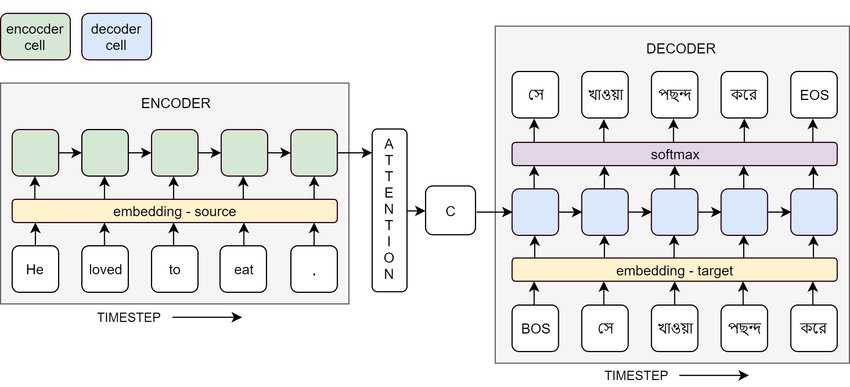


In [ ]:
# Paso 6: Traducir el texto al inglés usando MarianMT
src_text = transcription_es

tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-es-en')
model_1 = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-es-en')

translated = model_1.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
translation_en = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

print("Traducción al Inglés:", translation_en[0])

Traducción al Inglés: Fast and fast action as has rarely been seen, it is most likely from George Miller’s latest work. Chris Hemsworth offers an incredibly fun and deranged performance, one of the best in 10 years. Adding ferocious looks like the title character and the supporting cast keep the same level.


In [ ]:
# Analizar el sentimiento del texto traducido usando BERT
from transformers import pipeline

# Cargar el pipeline de análisis de sentimientos
sentiment_analysis = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Analizar el sentimiento del texto traducido
sentiment_result = sentiment_analysis(translation_en[0])
print("Análisis de Sentimiento:", sentiment_result)

Análisis de Sentimiento: [{'label': 'POSITIVE', 'score': 0.999774158000946}]


Pregunta: Vale la pena realizar fine tuning si podriamos asignar un rangos de confianza y ponerles una etiqueta ?

In [ ]:
import numpy as np
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

output_dir = "/content/drive/MyDrive/model_save"
# Para cargar el modelo y el tokenizador en otro entorno

loaded_tokenizer = AutoTokenizer.from_pretrained(output_dir)
loaded_model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Verificar que el modelo y el tokenizador se cargaron correctamente
print("Model and tokenizer loaded successfully.")


Model and tokenizer loaded successfully.


In [ ]:
import torch

In [ ]:
# Ejemplos de frases de prueba
#test_phrases = ["The movie was fantastic!", "I did not like the film at all.", "It was an average experience.", "The plot was very engaging.", "The acting was terrible."]
test_phrases = [translation_en[0]]
# Tokenizar las frases de prueba
inputs = loaded_tokenizer(test_phrases, padding=True, truncation=True, return_tensors="pt")

# Mover los inputs al dispositivo adecuado
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loaded_model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Hacer predicciones
with torch.no_grad():
    outputs = loaded_model(**inputs)
    predictions = outputs.logits.argmax(dim=-1)


In [ ]:
# Mostrar los resultados
for phrase, prediction in zip(test_phrases, predictions):
    print(f"Phrase: {phrase} | Sentiment: {prediction.item()}")

#  mapeo de los índices de las etiquetas a las clases de sentimiento
label_map = {0: "Negativa", 1: "Algo negativa", 2: "Neutral", 3: "Algo Positiva", 4: "Positiva"}
# Mostrar los resultados con etiquetas de sentimiento
for phrase, prediction in zip(test_phrases, predictions):
    sentiment_label = label_map[prediction.item()]
    print(f"Frase: {transcription_es} | Opinion: {sentiment_label}")

Phrase: There is a thin line between the sympathetically untying and the blundering, and the Count of Montecristo never decants the whole on either side. | Sentiment: 2
Frase:  Hay una delgada línea entre lo simpáticamente unticuado y lo chapuzero, y el Conde de Montecristo nunca se decanta el todo por ninguno de los dos lados. | Opinion: Neutral


In [ ]:
for phrase, prediction in zip(test_phrases, predictions):
    sentiment_label = label_map[prediction.item()]
    print(f"Frase: {transcription_es} | Opinion: {sentiment_label}")

Frase:  Esta película tenía momentos en los que podría haber sido una película brillante si no hubiera ido por un camino similar a la mayoría de las películas modernas en los últimos tiempos y la gente gritaba audiblemente en nuestro teatro cada vez que la trama o el desarrollo del personaje iban por ese camino. | Opinion: Algo negativa


In [ ]:
for phrase, prediction in zip(test_phrases, predictions):
    sentiment_label = label_map[prediction.item()]
    print(f"Frase: {transcription_es} | Opinion: {sentiment_label}")

Frase:  Acción rápida y trepidante como pocas veces se ha visto, muy probablemente es de la última obra de George Miller. Chris Hemsworth ofrece una actuación increíblemente divertida y desquiciada, una de las mejores en 10 años. Añas de unas miradas feroces como el personaje del título y el elenco de apoyo se mantienen el mismo nivel. | Opinion: Positiva


# SCRIPT EN PYTHON

In [ ]:
from fastapi import FastAPI, UploadFile, File
import whisper
from transformers import MarianMTModel, MarianTokenizer, pipeline, AutoTokenizer, AutoModelForSequenceClassification
import uvicorn
import numpy as np
import pandas as pd
import torch
import os

app = FastAPI()

# Cargar el modelo y el tokenizador
output_dir = "/content/drive/MyDrive/model_save"
loaded_tokenizer = AutoTokenizer.from_pretrained(output_dir)
loaded_model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Cargar los modelos preentrenados
whisper_model = whisper.load_model("small")
translation_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-es-en")
translation_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-es-en")
#sentiment_analysis = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

@app.post("/analyze/")
async def transcribe_translate(file: UploadFile = File(...)):
    # Guardar el archivo subido
    with open("temp_audio_file.mp3", "wb") as buffer:
        buffer.write(file.file.read())

    # Transcribir el audio en español
    result_es = whisper_model.transcribe("temp_audio_file.mp3", language='es')
    transcription_es = result_es['text']

    # Traducir el texto al inglés
    translated = translation_model.generate(**translation_tokenizer(transcription_es, return_tensors="pt", padding=True))
    translation_en = [translation_tokenizer.decode(t, skip_special_tokens=True) for t in translated]

    # Tokenizar la frase de prueba
    test_phrases = [translation_en[0]]
    inputs = loaded_tokenizer(test_phrases, padding=True, truncation=True, return_tensors="pt")

    # Mover los inputs al dispositivo adecuado
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loaded_model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Hacer predicciones
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        predictions = outputs.logits.argmax(dim=-1)

    # Mapeo de los índices de las etiquetas a las clases de sentimiento
    label_map = {0: "Negativa", 1: "Algo negativa", 2: "Neutral", 3: "Algo positiva", 4: "Positiva"}
    sentiment_label = label_map[predictions.item()]

    #return {"transcription_es": transcription_es, "translation_en": translation_en[0]}
    # Analizar el sentimiento del texto traducido
    #sentiment_result = sentiment_analysis(translation_en)[0]

    return {
        "transcription_es": transcription_es,
        # "translation_en": translation_en,
        "sentiment": sentiment_label
    }

if __name__ == "__main__":

    uvicorn.run(app, host="localhost", port=8080)
